In [4]:
import numpy as np
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag,\
Normal, ParamMixture
import tensorflow as tf
import matplotlib.pyplot as plt

Create toy data. We assume that an observation is drawn from one of two multivariate normal distributions, which make up two groups or clusters.

In [5]:
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

    return x

N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N)

The likelihood of an observation depends the probability with which it is in each of the cluster and the probability of the value given the distribution within the cluster

$p(x_n|\pi,\mu\sigma) = \sum^K_{k=1} {\pi_k} \cdot \texttt{Normal}(x_n|\mu_k, \sigma_k)$

The generative process can be described as:

1. For each k = 1,2:

    - $\mu_k \sim Normal(0, 1)$    
    - $\sigma_k \sim InverseGamma(1, 1)$

2. For each observation n = 1,..., N:

    1. $pi_i \sim Dirichlet(1_k)$    
    2. $x_n \sim Normal(\mu^{\pi_i}, \sigma^{\pi_i})$    

$\pi$ is a distribution over values in [0;1] that sum up to 1, in other words a mixture over the cluster assignment.

The dirichlet distribution is initialized for K dimensions with a hyperparameter for each dimension. For simplicity, here $\alpha_k = \alpha = 1$

**TODO**: Could the K be a random variable with a categorical prior? Probably not, but how would Dirichlet Process look like?

In [9]:
K = 3
pi = Dirichlet(tf.ones(K)) # Concentration [1.,1.]]

Each observed variable is assumed to come from a (multivariate-)normal distribution of dimension D. The priors for the means are 0 and for the variance are 1. *sample_shape* defines the number of times/rows that are drawn from the distribution.

In [10]:
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)

In [12]:
mu # shape [K, D] <> [Clusters, Distribution parameters]

<ed.RandomVariable 'Normal_1/' shape=(3, 2) dtype=float32>

For example, the first cluster comes from a multinormal distribution with mean -0.5 and 0.5, while the second cluster could be drawn from a distribution with means 0.5 and -0.5. Below is a random draw form *mu* that shows the shape:

The magic happens in the parameter mixture. **TODO**: How does this work exactly?

In [13]:
x = ParamMixture(pi, # The mixture parameter 
                 {'loc':mu, 'scale_diag': tf.sqrt(sigmasq)}, # The parameters of the distribution
                 MultivariateNormalDiag, # The distribution to sample from
                 sample_shape = N) # The number of samples

In [14]:
z = x.cat # Which mixture component generated the observation

## Inference with Gibbs sampling

In [7]:
T = 500 # Number of iterations in Gibbs sampling. MCMC samples

**TODO**: how exactly does get_variable() work, what are the alternatives?

In [8]:
#tf.reset_default_graph() # Drop all variables if code is run again

In [9]:
from edward.models import Empirical

qpi = Empirical(tf.get_variable(
"qpi/params", [T, K], # Nr. samples x dimensionality of groups
initializer = tf.constant_initializer(1.0/K))) # Initialized with uniform mixture

qmu = Empirical(tf.get_variable(
"qmu/params", [T, K, D],
initializer = tf.zeros_initializer())) # Samples x ( Nr of groups x Nr of vars )

qsigmasq = Empirical(tf.get_variable(
"qsigmasq/params", [T, K ,D],
initializer = tf.ones_initializer()))

qz =Empirical(tf.get_variable(
"qz/params", [T, N],
initializer = tf.zeros_initializer(),
dtype=tf.int32))

In [10]:
from edward.inferences import Gibbs
inference = Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [12]:
inference.run(n_print=50)

500/500 [100%] ██████████████████████████████ Elapsed: 12s | Acceptance Rate: 1.000


## Model criticism

Sample from the posterior distribution for each observation

In [13]:
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)

In [14]:
mu_sample.shape # 100 samples for two variables taken from 2 clusters

TensorShape([Dimension(100), Dimension(2), Dimension(2)])

For each of the N=500 Observation, we have 100 samples for 2 variables from 2 clusters

In [15]:
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))

In [16]:
x_post.shape 

TensorShape([Dimension(500), Dimension(100), Dimension(2), Dimension(2)])

Match the predictions to the data by replicating the data 100 (samples) x 2 (latent variables) times.

In [17]:
x_train.shape

(500, 2)

In [18]:
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

In [19]:
x_broadcasted.shape

TensorShape([Dimension(500), Dimension(100), Dimension(2), Dimension(2)])

Calculate the log likelihood of the each observation under the posterior distribution

In [20]:
log_liks = x_post.log_prob(x_broadcasted)

Sum over all variables (D) for the overall log likelihood and average over all samples (100, index 1)

In [21]:
log_liks.shape

TensorShape([Dimension(500), Dimension(100), Dimension(2), Dimension(2)])

In [22]:
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

The maximum likelihood along the latent cluster assignment over all samples gives the cluster predictions

In [23]:
clusters = tf.argmax(log_liks, 1).eval()

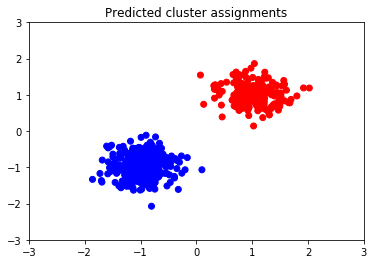

In [24]:
import matplotlib.cm as cm
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()